In [12]:
import numpy as np
import pandas as pd

In [13]:
df = pd.read_csv("dataset/train.csv")

In [14]:
df.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,2ZR62O53,6196161750,215250,222720,27716,3246298,1734810,93036735,1,0,English
1,ZJ31SS7Q,6091677300,211845,310998,25610,5310163,1370184,89705964,1,0,English
2,I31VI9RK,5644590915,515280,387315,10976,1767635,1023779,102611607,1,1,Portuguese
3,6GP9WLYR,3970318140,517740,300575,7714,3944850,703986,106546942,1,0,English
4,3DVR0TDD,3671000070,123660,285644,29602,8938903,2068424,78998587,1,0,English


In [15]:
def normalize(df, col, mm_dict):
    mean = df[col].mean()
    sd = df[col].std()
    new_df = (df[col] - mean) / (sd)
    df.update(new_df)
    mm_dict[col] = [mean, sd]
    return df, mm_dict

def normalize_data(df, col_list):
    mm_dict = dict()
    for col in col_list:
        df, mm_dict = normalize(df, col, mm_dict)
    return df, mm_dict


def normalize_reverse(data, col_name, mm_dict):
    return data * mm_dict[col_name][1] + mm_dict[col_name][0] 

In [16]:
normalize_col = ["Watch time(Minutes)", "Stream time(minutes)", "Peak viewers", "Average viewers", "Followers", "Followers gained", "Views gained"]
df, normalize_dict = normalize_data(df, normalize_col)
languages = pd.get_dummies(df["Language"]).head()
df = df.drop(columns=["Channel", "Language"])
df = df.append(languages).fillna(0)

In [17]:
y_train = np.expand_dims(df["Followers gained"].values, axis=1)
df = df.drop(columns="Followers gained")
X_train = df.values

C:\Users\ktjkt\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Feature: 0, Score: 0.04000
Feature: 1, Score: 0.05426
Feature: 2, Score: 0.09077
Feature: 3, Score: 0.17420
Feature: 4, Score: 0.58933
Feature: 5, Score: 0.04694
Feature: 6, Score: 0.00166
Feature: 7, Score: 0.00285
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000


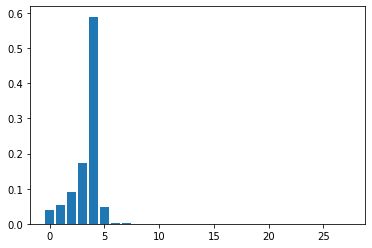

In [18]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
model = RandomForestRegressor()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [19]:
X_train = X_train[:,:8]

In [20]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Activation, Input, Add, Concatenate, Conv1D, Flatten, LSTM, Bidirectional

class MyANN(keras.Model):
    def __init__(self, input_size, hidden_sizes, batch_size = 100, activation="relu", dropout_rate=0.0, batch_norm=False):
        super(MyANN, self).__init__()
        self.dnn = Sequential()
        for i in range(len(hidden_sizes)-1):
            if i == 0:
                self.dnn.add(Dense(hidden_sizes[i],
                            input_dim=input_size))
            else:
                self.dnn.add(Dense(hidden_sizes[i+1],
                            input_dim=hidden_sizes[i]))
            if batch_norm:
                self.dnn.add(BatchNormalization())
            self.dnn.add(Activation(activation))
            if dropout_rate > 0.0:
                self.dnn.add(Dropout(dropout_rate, seed=1996))
        self.dense = Dense(1,
                    input_dim=hidden_sizes[-1])

    def call(self, x):
        x = self.dnn(x)
        x = self.dense(x)
        return x

In [21]:
def root_mean_squared_error(y_true, y_pred):
    return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true), axis=-1)) 

In [35]:
batch_size = 32
hidden_sizes = [8, 16, 32, 64, 128, 256, 64, 32, 8]
ANN = MyANN(input_size=X_train.shape[-1], hidden_sizes=hidden_sizes, batch_norm=True, dropout_rate = 0.15)
optimizer='Adam'
learning_rate=1e-3
metrics = [tf.keras.metrics.RootMeanSquaredError()]

ANN.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics=metrics)
history = ANN.fit(X_train, y_train, validation_split=0.1,
                    epochs=300, batch_size=batch_size, verbose=1)

Epoch 1/300

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 0s 13ms/step - loss: 0.6749 - root_mean_squared_error: 1.1283 - val_loss: 0.3642 - val_root_mean_squared_error: 0.4141
Epoch 2/300
23/23 [==============================] - 0s 6ms/step - loss: 0.5806 - root_mean_squared_error: 1.0179 - val_loss: 0.3337 - val_root_mean_squared_error: 0.3858
Epoch 3/300
23/23 [==============================] - 0s 6ms/step - loss: 0.5486 - root_mean_squared_error: 1.0070 - val_loss: 0.3081 - val_root_mean_squared_error: 0

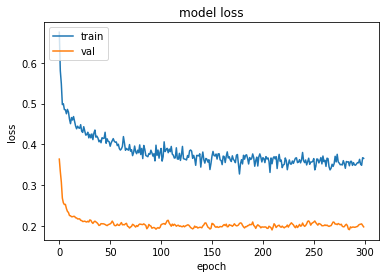

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [37]:
test = pd.read_csv("dataset/test.csv")

In [38]:
def normalize_test(df, col_names, mm_dict):
     for col in col_names:
          new_df = (df[col] - mm_dict[col][0]) / (mm_dict[col][1])
          df.update(new_df)
     return df

In [39]:
test_min_max_col = ["Watch time(Minutes)", "Stream time(minutes)", "Peak viewers", "Average viewers", "Followers", "Views gained"]
test = test.drop(columns=["Channel", "Language"])
test = normalize_test(test, test_min_max_col, normalize_dict)

In [40]:
X_test = test.values
pred_test = ANN.predict(X_test)
pred_test = normalize_reverse(pred_test, "Followers gained", normalize_dict)

In [41]:
submit = pd.read_csv("dataset/test.csv")
submit = submit.drop(columns=["Language","Watch time(Minutes)", "Stream time(minutes)", "Peak viewers", "Average viewers", "Followers", "Views gained", "Partnered", "Mature"])
submit["Followers gained"] = pred_test

In [42]:
submit.to_csv("dataset/submission.csv", index=False)